In [30]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque

%matplotlib inline

In [35]:
env = gym.make('CartPole-v0')

# Properties of the environment
# vector of 4
state_space = env.observation_space

print('Low: ', state_space.low)
print('High: ', state_space.high)

# vector of 2
action_space = env.action_space

print('States: ', state_space)
print('Actions: ', action_space)

state_size = state_space.shape[0]
action_size = action_space.n
print('State vector size: ', state_size)
print('Actions vector size: ', action_size)

class Agent(nn.Module):
    def __init__(self, env, state_size, hidden_size, action_size, gamma):
        super(Agent, self).__init__()
        
        torch.manual_seed(505)
        env.seed(0)
        np.random.seed(0)
        
        self.env = env
        self.input_size = state_size
        self.hidden_size = hidden_size
        self.output_size = action_size
        
        self.gamma = gamma
        
        device_type = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device(device_type)
        print('Using \"%s\" device' % device_type)
        
        # Note: Stochastic policy function approximator
        self.fc1 = nn.Linear(in_features=self.input_size, out_features=self.hidden_size, bias=True).to(self.device)
        self.fc2 = nn.Linear(in_features=self.hidden_size, out_features=self.output_size, bias=True).to(self.device)
        
        # Note: More efficient to use 1D array (1 is added for the bias)
        fc1_bias_size = (self.input_size + 1) * self.hidden_size
        fc2_bias_size = (self.hidden_size + 1) * self.output_size
        self.total_size = fc1_bias_size + fc2_bias_size
        
        # Note: Very important how this is initialized
        self.flat_weights = 1e-4 * np.random.rand(self.total_size)
        
        self.set_weights()
        
        # Note: Used in order to decide on the adaptive random radius (adaptive scale hill climbing algorithm)
        self.last_reward = -np.Inf
        
        self.up_fraction = 2
        self.down_fraction = 1e-3
        
    def forward(self, state):
        state = state.to(self.device)
        action_probs = self.fc2( F.leaky_relu( self.fc1( state ) ) )
        return torch.softmax(action_probs, dim=0)
    
    def set_weights(self):
        fc1_stride = self.input_size * self.hidden_size
        b1_stride = fc1_stride + self.hidden_size
        
        self.w1 = torch.from_numpy( self.flat_weights[ : fc1_stride ].reshape( self.input_size, self.hidden_size ) ).float().to(self.device)
        self.b1 = torch.from_numpy( self.flat_weights[ fc1_stride : b1_stride ].reshape( 1, self.hidden_size ) ).float().to(self.device)
        
        fc2_stride = b1_stride + self.hidden_size * self.output_size
        
        self.w2 = torch.from_numpy( self.flat_weights[ b1_stride : fc2_stride ].reshape( self.hidden_size, self.output_size ) ).float().to(self.device)
        self.b2 = torch.from_numpy( self.flat_weights[ fc2_stride : ].reshape( 1, self.output_size ) ).float().to(self.device)
    
    # Note: Perturb with adaptive Gaussian noise
    def update_weights(self, reward, sigma):
        if reward <= self.last_reward:
            sigma += self.up_fraction
            self.flat_weights = sigma * np.random.rand(self.total_size)
        else:
            sigma -= self.down_fraction
            self.flat_weights += sigma * np.random.rand(self.total_size)
            self.last_reward = reward
        
        self.set_weights()
        
        self.fc1.weight.data.copy_(self.w1.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(self.b1.view_as(self.fc1.bias.data))
        
        self.fc2.weight.data.copy_(self.w2.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(self.b2.view_as(self.fc2.bias.data))
        
        return sigma
        
gamma = 0.95
hidden_size = 16
agent = Agent(env, state_size, hidden_size, action_size, gamma)

Low:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
High:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
States:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Actions:  Discrete(2)
State vector size:  4
Actions vector size:  2
Using "cuda:0" device


In [36]:
def run(env, agent, nepisodes):
    average_scores = deque(maxlen=100)
    sigma = 1e-2
    
    scores = []
    
    for episode_idx in range(1, nepisodes + 1):
        state = env.reset()
        
        score = 0
        episode_rewards = []
        while True:
            actions = agent.forward( torch.from_numpy(state).float() )
            
            next_state, reward, done, _ = env.step(actions.argmax().item())
            
            # Q = R + SUM(j^i-1.Ri)
            episode_rewards.append(reward)
            score += np.sum([ (gamma**idx) * episode_rewards[idx] for idx in range(0, len(episode_rewards)) ])

            sigma = agent.update_weights(score, sigma)

            state = next_state
            
            if done:
                scores.append(score)
                average_scores.append(score)
                break
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode_idx, np.mean(average_scores)), end='')
        
        if np.mean(average_scores) >= 195.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode_idx - 100, np.mean(average_scores)))
            break
            
    return scores
        
scores = run(env, agent, 2000)

Episode 86	Average Score: 195.86
Environment solved in -14 episodes!	Average Score: 195.86


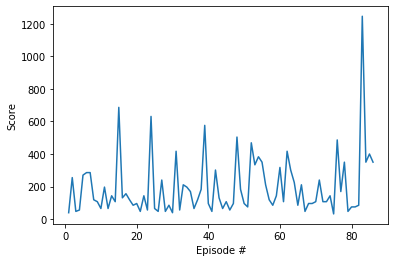

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [38]:
# load the weights from file
state = env.reset()
while True:
    state = torch.from_numpy(state).float()
    with torch.no_grad():
        action = agent.forward(state)
    env.render()
    next_state, reward, done, _ = env.step(action.argmax().item())
    state = next_state
    if done:
        break

env.close()